# Stochastic Modelling of Pattern Formation

*citation:*
Twomey, Aidan. "On the stochastic modelling of reaction-diffusion processes." (2007).
https://core.ac.uk/download/pdf/1568321.pdf

$$
2U + V \xrightarrow{k1} 3U \quad\quad\text{(6.1)}\\
\emptyset \xrightarrow{k2} U \quad\quad\quad\quad\text{(6.2a)}\\
U \xrightarrow{k3} \emptyset \quad\quad\quad\quad\text{(6.2b)}\\
\emptyset \xrightarrow{k4} V \quad\quad\quad\quad\text{(6.3)}
$$

In [89]:
import os
import sys
from collections import OrderedDict
sys.path.append("../..")
import spatialpy
print(spatialpy.__file__)
import matplotlib.pyplot as plt
import numpy
%load_ext autoreload
%autoreload 2

/home/brian/Desktop/research/SpatialPy/examples/turing_pattern/../../spatialpy/__init__.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
class All(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return True

In [280]:
class turingPattern(spatialpy.Model):

    def __init__(self, model_name="turingPattern"):
        spatialpy.Model.__init__(self, model_name)

        
        U = spatialpy.Species(name="U", diffusion_constant=5e-4) # units: mm^2 s^-1
        V = spatialpy.Species(name="V", diffusion_constant=0.06) # units: mm^2 s^-1
        # 1 mm^2 = 1000000 um^2
        #U = spatialpy.Species(name="U", diffusion_constant=5e2)  # units: um^2 s^-1
        #V = spatialpy.Species(name="V", diffusion_constant=60000)  # units: um^2 s^-1
        self.add_species([U,V])

        self.domain = spatialpy.Domain.create_2D_domain(nx=30, ny=30, xlim=[0, 1], ylim=[0, 1], fixed=True)

        self.set_type(All(), 1)

        k1 = spatialpy.Parameter("k1", expression=123.45)  #Note that the paper uses mixed units 
        k2 = spatialpy.Parameter("k2", expression=0.09)    # we may need to convert all units to the same
        k3 = spatialpy.Parameter("k3", expression=2.0)
        k4 = spatialpy.Parameter("k4", expression=0.27)
        
        #k1 = spatialpy.Parameter("k1", expression=.0012345) 
        #k2 = spatialpy.Parameter("k2", expression=9.0)
        #k3 = spatialpy.Parameter("k3", expression=2.0)
        #k4 = spatialpy.Parameter("k4", expression=27.0)
        self.add_parameter([k1, k2, k3, k4])

        #Reaction1 = spatialpy.Reaction(reactants={U:2, V:1}, products={U:3}, 
        #                               propensity_function="(U*(U-1)*V*k1)/((1./30)*(1./30)*(1./30)*(1./30))")
        #Reaction2 = spatialpy.Reaction(reactants={}, products={U:1}, propensity_function="k2*(1./30)*(1./30)")
        #Reaction3 = spatialpy.Reaction(reactants={U:1}, products={}, rate="k3")
        #Reaction4 = spatialpy.Reaction(reactants={}, products={V:1}, propensity_function="k4*(1./30)*(1./30)")

        Reaction1 = spatialpy.Reaction(reactants={V:1}, products={U:1}, 
                                       propensity_function="(U*(U-1)*V*k1)/vol/vol")
        Reaction2 = spatialpy.Reaction(reactants={}, products={U:1}, rate="k2")
        Reaction3 = spatialpy.Reaction(reactants={U:1}, products={}, rate="k3")
        Reaction4 = spatialpy.Reaction(reactants={}, products={V:1}, rate="k4")
        
        
        self.add_reaction([Reaction1, Reaction2, Reaction3, Reaction4])
        
        u_star = 0.18
        v_star = 0.065
        uv_scaling_factor = 1000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(U, int(u_star*uv_scaling_factor), [1]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(V, int(v_star*uv_scaling_factor), [1]))
        
        #u_star = (self.listOfParameters['k2'].value + self.listOfParameters['k4'].value) / self.listOfParameters['k3'].value
        #v_star = (self.listOfParameters['k4'].value/self.listOfParameters['k1'].value)*( self.listOfParameters['k3'].value/(self.listOfParameters['k2'].value+self.listOfParameters['k4'].value) )**2
        #uv_scaling_factor=1
        #self.add_initial_condition(spatialpy.UniformInitialCondition(U, int(u_star*uv_scaling_factor), [1]))
        #self.add_initial_condition(spatialpy.UniformInitialCondition(V, int(v_star*uv_scaling_factor), [1]))
                
        print(f"u_star = {u_star}")
        print(f"v_star = {v_star}")

        self.staticDomain = True

        #self.timespan(range(0,50))
        self.timespan(numpy.linspace(0,200,11),timestep_size = 1)

In [281]:
model = turingPattern()

u_star = 0.18
v_star = 0.065


In [282]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 1.72 s
/tmp/spatialpy_build_2zpgcnvx


In [283]:
%time result = sol.run()

CPU times: user 2.9 ms, sys: 4.27 ms, total: 7.17 ms
Wall time: 3.14 s


In [284]:
speciesU = result.get_species("U")
speciesV = result.get_species("V")

In [285]:
speciesU.sum(axis=1)
speciesV.sum(axis=1)

array([65.,  5.,  9., 14., 19., 22., 24., 30., 35., 41., 46.])

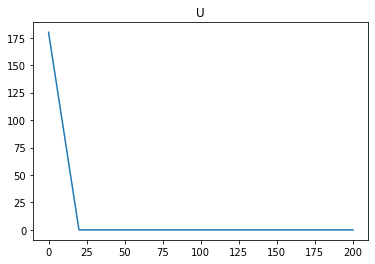

In [286]:
plt.plot(result.get_timespan(), speciesU.sum(axis=1))
_=plt.title('U')

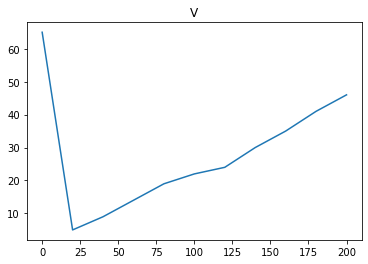

In [287]:
plt.plot(result.get_timespan(), speciesV.sum(axis=1))
_=plt.title('V')

In [288]:
#result.plot_species("U", animated=True)

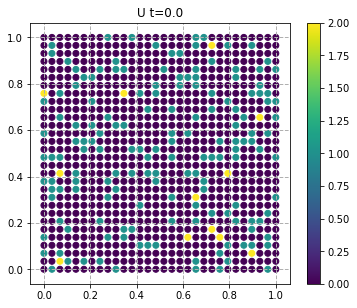

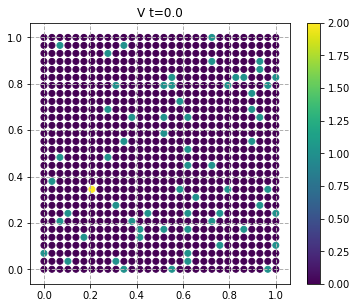

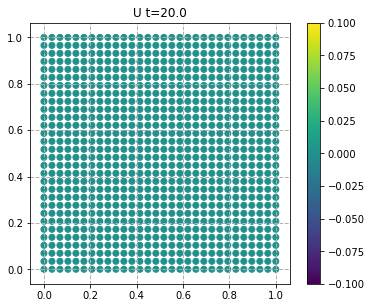

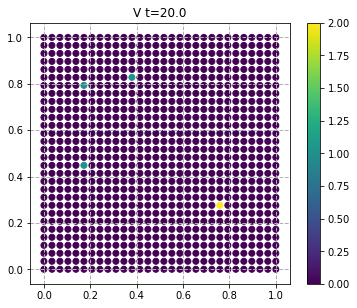

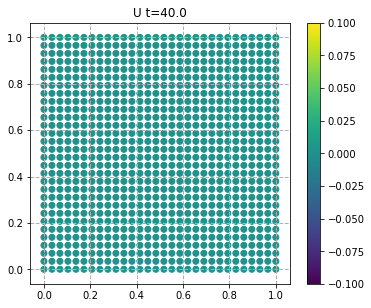

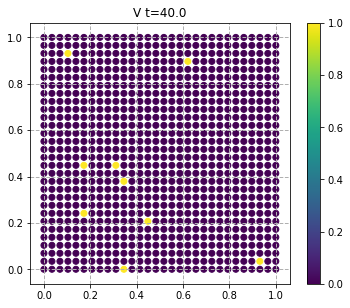

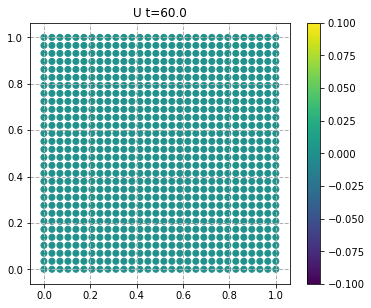

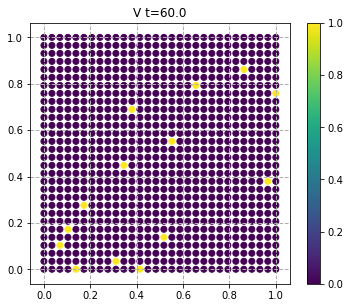

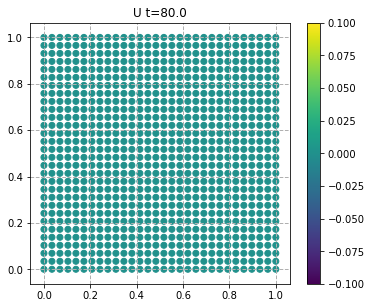

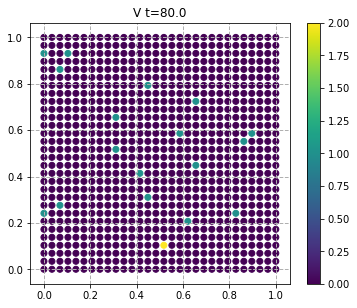

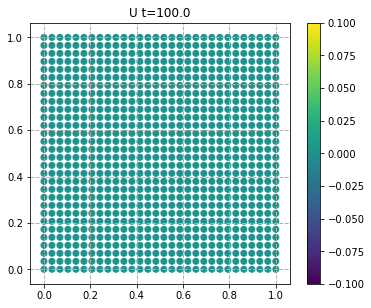

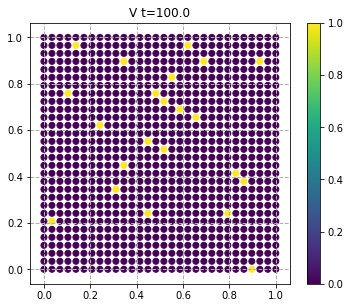

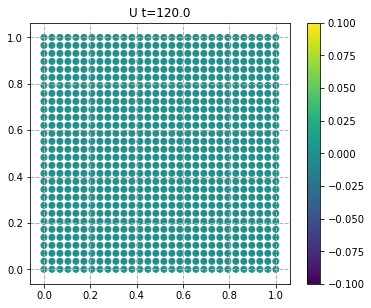

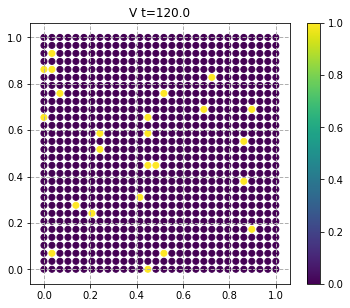

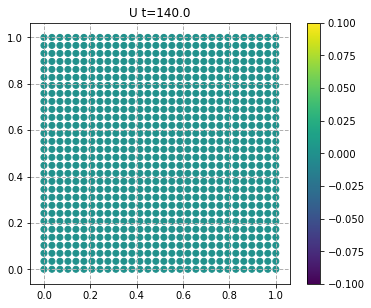

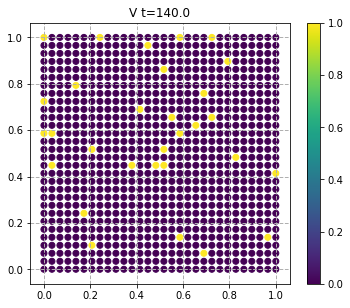

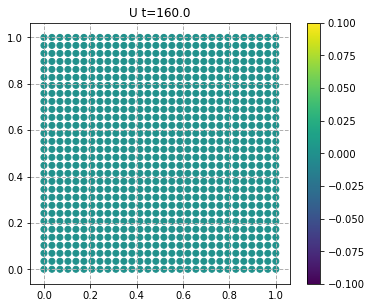

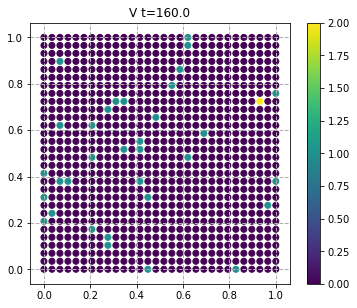

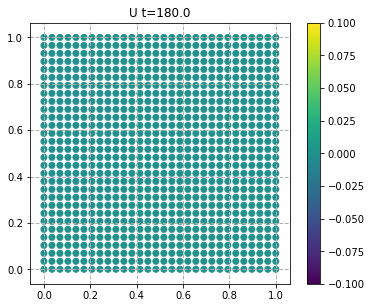

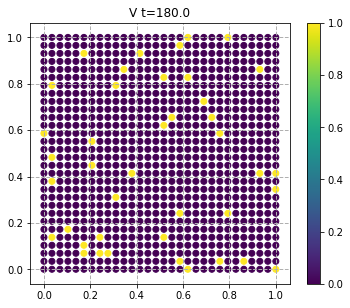

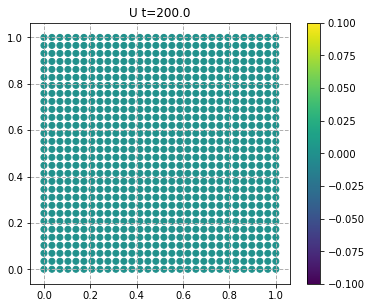

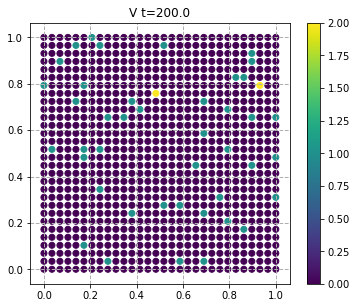

In [296]:
for i,t in enumerate(result.get_timespan()):
    #print(i,t)
    result.plot_species("U", i, use_matplotlib=True)
    plt.title(f"U t={t}")
    result.plot_species("V", i, use_matplotlib=True)
    plt.title(f"V t={t}")